---
# PREPARATION

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import layers, Model
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

time: 3.24 ms (started: 2021-02-21 13:15:13 +00:00)


In [ ]:
tf.__version__

'2.4.1'

time: 4.23 ms (started: 2021-02-21 13:15:14 +00:00)


In [ ]:
#@title Record Each Cell's Execution Time
!pip install ipython-autotime

%load_ext autotime

In [ ]:
#pip install --upgrade tensorflow

time: 659 µs (started: 2021-02-21 13:15:17 +00:00)


In [ ]:
#drive.mount("/gdrive", force_remount=True)

time: 447 µs (started: 2021-02-21 13:15:17 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/'Colab Notebooks'/
%ls

In [ ]:
def save_dataset(dataset,fileName):
  path = os.path.join('./tfDatasets/', fileName)
  tf.data.experimental.save(dataset, path)

def load_dataset(fileName):
  path = os.path.join("./tfDatasets/", fileName)
  new_dataset = tf.data.experimental.load(path,
      tf.TensorSpec(shape=(), dtype=tf.string))
  return new_dataset

time: 11.7 ms (started: 2021-02-21 13:15:17 +00:00)


---
# Building an Efficient TensorFlow Input Pipeline  for Word-Level Text Generation


This tutorial is the **third** part of the "**Text Generation in Deep Learning with Tensorflow & Keras**" series.

In this series, we have been covering all the  topics related to Text Generation with sample implementations in **Python**.

In this tutorial, we will focus on how to **build an Efficient TensorFlow Input Pipeline for Word-Level Text Generation**.

**First**, we will download a sample  corpus (text file). 

**After** opening the file and reading it line-by-line, we will split the text into word tokens.

**Then**, we will generate tuples including an input word sequence (X) and an output word (y).

**Using** tf.data API and Keras TextVectorization method, we will 
* preprocess the text, 
* convert the words into integer representation, 
* prepare the training dataset from the pairs,
* optimize the data pipeline.

Thus, **in the end**, we will have the proper dataset to train a Language Model for word-level text generation.


If you would like to learn more about **Deep Learning** with practical coding examples, please subscribe to [Murat Karakaya Akademi YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA)  or follow [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **notifications** so that you will be notified when new parts are uploaded.

You can access this **Colab Notebook** using the link given in the video description below.

If you are ready, let's get started!



## [Text Generation in Deep Learning with Tensorflow & Keras Series:](https://kmkarakaya.medium.com/text-generation-in-deep-learning-with-tensorflow-keras-e403aee375c1)

**Part A**: Fundamentals 

**Part B**: Tensorflow Data Pipeline for Character Level Text Generation

**Part C**: ***Tensorflow Data Pipeline for Word Level Text Generation***

**Part D**: Recurrent Neural Network (LSTM) Model for Character Level Text Generation

**Part E**: Encoder-Decoder Model for Character Level Text Generation

**Part F**: Recurrent Neural Network (LSTM) Model for Word Level Text Generation

**Part G**: Encoder-Decoder Model for Word Level Text Generation


You can **watch** all these parts on [Murat Karakaya Akademi channel on YouTube](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA) in **[ENGLISH](https://youtube.com/playlist?list=PLQflnv_s49v9QOres0xwKyu21Ai-Gi3Eu)** or **[TURKISH](https://youtube.com/playlist?list=PLQflnv_s49v-oEYNgoqK5e4GyUbodfET3)**

I **assume** that ***you have already watched all previous parts***.
Please ensure that you have reviewed the previous parts in order to utilize this part better.



## References

[What is a Data Pipeline?](https://www.alooma.com/blog/what-is-a-data-pipeline)


[tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)


[Text classification from scratch](https://keras.io/examples/nlp/text_classification_from_scratch/)

[Working with Keras preprocessing layers](https://keras.io/guides/preprocessing_layers/)

[Character-level text generation with LSTM](https://keras.io/examples/generative/lstm_character_level_text_generation/)


[Toward Controlled Generation of Text](https://arxiv.org/abs/1703.00955)

[Attention Is All You Need](https://arxiv.org/abs/1706.03762)

[Talk to Transformer](https://app.inferkit.com/demo)

[What is the difference between word-based and char-based text generation RNNs?](https://datascience.stackexchange.com/questions/13138/what-is-the-difference-between-word-based-and-char-based-text-generation-rnns)

[The survey: Text generation models in deep learning](https://www.sciencedirect.com/science/article/pii/S1319157820303360)

[Generative Adversarial Networks for Text Generation](https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-1-2b886c8cab10)

[FGGAN: Feature-Guiding Generative Adversarial Networks for Text Generation](https://ieeexplore.ieee.org/abstract/document/9091179)

[How to sample from language models](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277)

[How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)

[Hierarchical Neural Story Generation](https://arxiv.org/abs/1805.04833)

# What is a Word Level Text Generation?
A **Language Model** can be trained to generate text **word-by-word**. 

In this case, each of the **input** and **output** tokens is made of **word** tokens. 

In training, we supply a sequence of words as input (X) and a target word (next word to complete the input) as output (y)

After training, the Language Model learns to generate **a conditional probability distribution** over the **vocabulary** of words according to the **given  input sequence**.


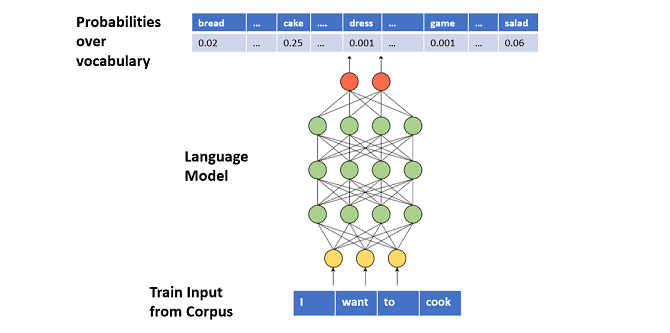

To generate text, we can iterate over the below steps: 
* **Step 1:** we provide **a sequence of words** to the Language Model as input
* **Step 2:** the Language Model outputs **a conditional probability distribution** over the **vocabulary**
* **Step 3:** we **sample** a word from the distribution
* **Step 4:** we **concatenate** the newly sampled word to the ***generated text***
* **Step 4:** **a new input sequence** is genareted by appending the newly sampled word


For more details, please check [Part A and B.](https://medium.com/mlearning-ai/text-generation-in-deep-learning-with-tensorflow-keras-f7cfd8d65d9e)

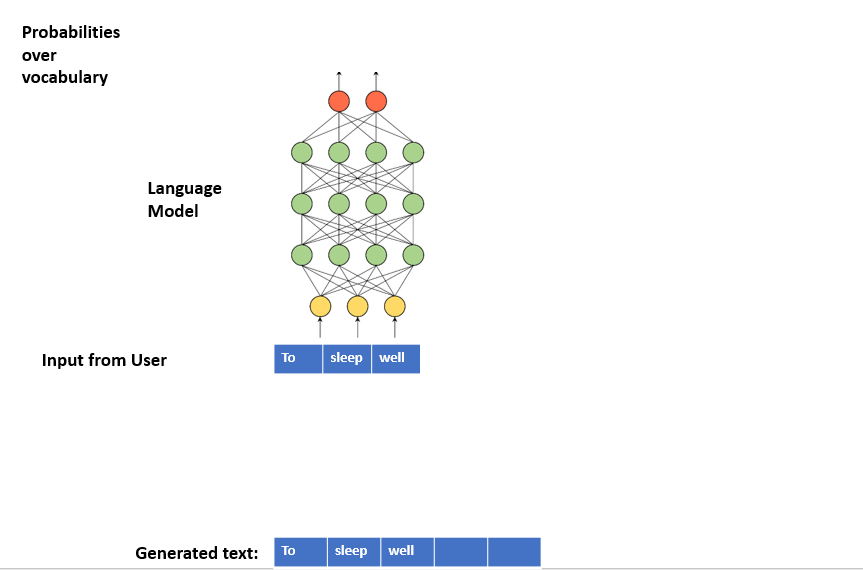

---
# Tensorflow Data Pipeline: tf.data

## What is a Data Pipeline?

Data Pipeline is an **automated** process that involves in **extracting**, **transforming**, **combining**, **validating**, and **loading** data for further analysis and visualization. 

It provides **end-to-end** velocity by ***eliminating*** errors and ***combatting*** bottlenecks or latency. 

It can process **multiple** data streams at once. 

In short, it is an **absolute necessity** for today’s data-driven solutions.

If you are **not familiar** with data pipelines, you can check my tutorials in [English](https://youtube.com/playlist?list=PLQflnv_s49v_m6KLMsORgs9hVIvDCwDAb) or [Turkish](https://youtube.com/playlist?list=PLQflnv_s49v8l8dYU01150vcoAn4sWSAm).


## Why Tensorflow Data Pipeline?

The **tf.data** API enables us 
* to build **complex** input pipelines from simple, reusable pieces. 

* to handle **large amounts of data**, read from **different data formats**, and perform **complex transformations**.




## What can be done in a Text Data Pipeline?

The pipeline for a text model might involve **extracting symbols** from raw text data, **converting** them to embedding identifiers with a lookup table, and **batching** together sequences of different lengths. 

## What will we do in this Text Data pipeline?

We will create a data pipeline to **prepare training data for word-level text generator**.

Thus, in the pipeline, we will
* **open** & **load** corpus (text file)
* **convert** the text into sequence of words
* **generate** input (X) and output (y) tuples as word sequences
* **remove** unwanted tokens such as punctuations, HTML tags, white spaces, etc.
* **vectorize** the input (X) and output (y) tuples
* **concatenate** input (X) and output (y) into train data
* **cache, prefetch, and batch** the data pipeline for performance





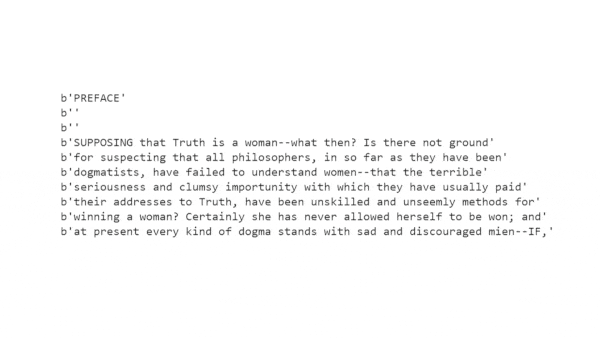

After, this brief introduction to the Tensorflow Data pipeline, let's start creating our text pipeline.

---
# Building an Efficient TensorFlow Input Pipeline  for Word-Level Text Generation

---
# 1. DOWNLOAD DATA


In [ ]:
#!curl -O https://s3.amazonaws.com/text-datasets/nietzsche.txt

time: 1.67 ms (started: 2021-02-21 13:15:17 +00:00)


In [ ]:
!curl -O https://raw.githubusercontent.com/kmkarakaya/ML_tutorials/master/data/mesnevi_Tumu.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2586k  100 2586k    0     0  30.8M      0 --:--:-- --:--:-- --:--:-- 30.8M
time: 158 ms (started: 2021-02-21 13:15:17 +00:00)


---
# 2. LOAD TEXT DATA LINE BY LINE

To load the data into our pipeline, I will use `tf.data.TextLineDataset()` method.

In [ ]:
#raw_data_ds = tf.data.TextLineDataset(["nietzsche.txt"])
raw_data_ds = tf.data.TextLineDataset(["mesnevi_Tumu.txt"])

time: 18.6 ms (started: 2021-02-21 13:15:17 +00:00)


Let's see some lines from the uploaded text:

In [ ]:
for elems in raw_data_ds.take(10):
    print(elems.numpy()) #.decode("utf-8")

b'1. Dinle, bu ney nas\xc4\xb1l \xc5\x9fik\xc3\xa2yet ediyor, ayr\xc4\xb1l\xc4\xb1klar\xc4\xb1 nas\xc4\xb1l anlat\xc4\xb1yor:'
b'Beni kam\xc4\xb1\xc5\x9fl\xc4\xb1ktan kestiklerinden beri feryad\xc4\xb1mdan erkek, kad\xc4\xb1n\xe2\x80\xa6 herkes a\xc4\x9flay\xc4\xb1p inledi.'
b'Ayr\xc4\xb1l\xc4\xb1ktan par\xc3\xa7a par\xc3\xa7a olmu\xc5\x9f, kalb isterim ki, i\xc5\x9ftiyak derdini a\xc3\xa7ay\xc4\xb1m.'
b'Asl\xc4\xb1nda uzak d\xc3\xbc\xc5\x9fen ki\xc5\x9fi, yine vuslat zaman\xc4\xb1n\xc4\xb1 arar.'
b''
b'5. Ben her cemiyette a\xc4\x9flad\xc4\xb1m, inledim. Fena hallilerle de e\xc5\x9f oldum, iyi hallilerle de.'
b'Herkes kendi zann\xc4\xb1nca benim dostum oldu ama kimse i\xc3\xa7imdeki s\xc4\xb1rlar\xc4\xb1 ara\xc5\x9ft\xc4\xb1rmad\xc4\xb1.'
b'Benim esrar\xc4\xb1m feryad\xc4\xb1mdan uzak de\xc4\x9fildir, ancak (her) g\xc3\xb6zde, kulakta o nur yok.'
b'Ten candan, can da tenden gizli kapakl\xc4\xb1 de\xc4\x9fildir, l\xc3\xa2kin can\xc4\xb1 g\xc3\xb6rmek i\xc3\xa7in kimseye izin yok.'
b'Bu

---
# 3. SPLIT THE TEXT INTO WORD TOKENS

**[In Part A](https://medium.com/mlearning-ai/text-generation-in-deep-learning-with-tensorflow-keras-f7cfd8d65d9e)**, we mentioned that we can train a language model and generate new text by using two different units:
* character level
* word level

That is, you can split your text into sequence of characters or words.

In this tutorial, we will focus on **word level** tokenization. 

If you would like to learn how to create **char level** tokenization please take a look at **[Part B](https://kmkarakaya.medium.com/text-generation-in-deep-learning-with-tensorflow-keras-e403aee375c1)**.



In [ ]:
raw_data_ds= raw_data_ds.map(lambda x: tf.strings.split(x))
for elems in raw_data_ds.take(5):
    print(elems.numpy())

[b'1.' b'Dinle,' b'bu' b'ney' b'nas\xc4\xb1l' b'\xc5\x9fik\xc3\xa2yet'
 b'ediyor,' b'ayr\xc4\xb1l\xc4\xb1klar\xc4\xb1' b'nas\xc4\xb1l'
 b'anlat\xc4\xb1yor:']
[b'Beni' b'kam\xc4\xb1\xc5\x9fl\xc4\xb1ktan' b'kestiklerinden' b'beri'
 b'feryad\xc4\xb1mdan' b'erkek,' b'kad\xc4\xb1n\xe2\x80\xa6' b'herkes'
 b'a\xc4\x9flay\xc4\xb1p' b'inledi.']
[b'Ayr\xc4\xb1l\xc4\xb1ktan' b'par\xc3\xa7a' b'par\xc3\xa7a'
 b'olmu\xc5\x9f,' b'kalb' b'isterim' b'ki,' b'i\xc5\x9ftiyak' b'derdini'
 b'a\xc3\xa7ay\xc4\xb1m.']
[b'Asl\xc4\xb1nda' b'uzak' b'd\xc3\xbc\xc5\x9fen' b'ki\xc5\x9fi,' b'yine'
 b'vuslat' b'zaman\xc4\xb1n\xc4\xb1' b'arar.']
[]
time: 84.1 ms (started: 2021-02-21 13:15:17 +00:00)


Flatten the dataset for further processing:

In [ ]:
raw_data_ds=raw_data_ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
for elems in raw_data_ds.take(5):
    print(elems.numpy())

b'1.'
b'Dinle,'
b'bu'
b'ney'
b'nas\xc4\xb1l'
time: 39.1 ms (started: 2021-02-21 13:15:17 +00:00)


In [ ]:
print("Vocabulary size (# of distinct words): ",len(set(raw_data_ds.as_numpy_iterator())))  # farkli kelime sayisi

Vocabulary size (# of distinct words):  77453
time: 26.6 s (started: 2021-02-21 13:14:30 +00:00)


# 4. GENERATE X & y TUPLES

We can split the text into two datasets  as below:
* The first dataset (**X**) is  the **input data** to the model which will hold fixed-size word sequences (*partial sentences*) 
* The second dataset (**y**) is  the **output data** which has only  one-word samples (*next word*)


To create these datasets (**X** ***input sequence of words*** & **y** ***next word***), we can apply `tf.data.Dataset.window()` transformation.

First, define the size of the input sequence: How many words will be in the input?



In [ ]:
input_sequence_size= 4

time: 1.04 ms (started: 2021-02-21 13:16:15 +00:00)


Then, apply the `window()` transformation such that each window will have `input_sequence_size+1` words (|X|+|y|)

In [ ]:
sequence_data_ds=raw_data_ds.window(input_sequence_size+1, drop_remainder=True)
for window in sequence_data_ds.take(3):
  print(list(window.as_numpy_iterator()))

[b'1.', b'Dinle,', b'bu', b'ney', b'nas\xc4\xb1l']
[b'\xc5\x9fik\xc3\xa2yet', b'ediyor,', b'ayr\xc4\xb1l\xc4\xb1klar\xc4\xb1', b'nas\xc4\xb1l', b'anlat\xc4\xb1yor:']
[b'Beni', b'kam\xc4\xb1\xc5\x9fl\xc4\xb1ktan', b'kestiklerinden', b'beri', b'feryad\xc4\xb1mdan']
time: 82.2 ms (started: 2021-02-21 13:16:18 +00:00)


However, the `window()` method returns a dataset containing ***windows***, where each window is itself represented as a **dataset**. Something like {{1,2,3,4,5},{6,7,8,9,10},...}, where {...} represents a dataset.

In [ ]:
print(window)  # dataset turu tensor olmali

<_VariantDataset shapes: (), types: tf.string>
time: 1.53 ms (started: 2021-02-21 13:16:18 +00:00)


 But we just want a regular dataset containing tensors: {[1,2,3,4,5],[6,7,8,9,10],...}, where [...] represents a tensor. The `flat_map()` method returns all the tensors in a nested dataset, after transforming each nested dataset. 
 
If we didn't batch, we would get: {1,2,3,4,5,6,7,8,9,10,...}. By batching each window to its full size, we get {[1,2,3,4,5],[6,7,8,9,10],...} as we desired.

You can find more details about the transformation [here](https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0)


In [ ]:
sequence_data_ds = sequence_data_ds.flat_map(lambda window: window.batch(5))  # icindeki methodu tum elemanlara uygularken birlestiriyor, tensor oluyor
for elem in sequence_data_ds.take(3):
  print(elem)

tf.Tensor([b'1.' b'Dinle,' b'bu' b'ney' b'nas\xc4\xb1l'], shape=(5,), dtype=string)
tf.Tensor(
[b'\xc5\x9fik\xc3\xa2yet' b'ediyor,' b'ayr\xc4\xb1l\xc4\xb1klar\xc4\xb1'
 b'nas\xc4\xb1l' b'anlat\xc4\xb1yor:'], shape=(5,), dtype=string)
tf.Tensor(
[b'Beni' b'kam\xc4\xb1\xc5\x9fl\xc4\xb1ktan' b'kestiklerinden' b'beri'
 b'feryad\xc4\xb1mdan'], shape=(5,), dtype=string)
time: 51.4 ms (started: 2021-02-21 13:16:18 +00:00)


Now each item in the dataset is a tensor, so we can split it into **X** & **y** datasets:

In [ ]:
sequence_data_ds = sequence_data_ds.map(lambda window: (window[:-1], window[-1:]))
X_train_ds_raw = sequence_data_ds.map(lambda X,y: X)
y_train_ds_raw = sequence_data_ds.map(lambda X,y: y)

time: 46.8 ms (started: 2021-02-21 13:16:18 +00:00)


Let's see some input-output pairs:

In [ ]:
print("Input X  (sequence) \t\t    ----->\t Output y (next word)")
for elem1, elem2 in zip(X_train_ds_raw.take(3),y_train_ds_raw.take(3)):
   print(elem1.numpy(),"\t\t----->\t", elem2.numpy())

Input X  (sequence) 		    ----->	 Output y (next word)
[b'1.' b'Dinle,' b'bu' b'ney'] 		----->	 [b'nas\xc4\xb1l']
[b'\xc5\x9fik\xc3\xa2yet' b'ediyor,' b'ayr\xc4\xb1l\xc4\xb1klar\xc4\xb1'
 b'nas\xc4\xb1l'] 		----->	 [b'anlat\xc4\xb1yor:']
[b'Beni' b'kam\xc4\xb1\xc5\x9fl\xc4\xb1ktan' b'kestiklerinden' b'beri'] 		----->	 [b'feryad\xc4\xb1mdan']
time: 83.7 ms (started: 2021-02-21 13:16:18 +00:00)


# 5. RESHAPE X DATASET

Input (X) is **a vector of strings** but we need to convert it to **a  string vector** so that we can vectorize it properly.

Below is a python function for iterating the given tensor to join all the strings into a single string:

In [ ]:
def convert_string(X: tf.Tensor):
  str1 = ""  
  for ele in X:
    str1 += ele.numpy().decode("utf-8")+" "
  str1= tf.convert_to_tensor(str1[:-1])
  return str1

time: 2.9 ms (started: 2021-02-21 13:16:19 +00:00)


We apply the `convert_string` function to every element of `X_train_ds_raw`

**Note that** to use a ***python function*** as a mapping function, you need to apply `tf.py_function()`. For more, please see the documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

In [ ]:
X_train_ds_raw=X_train_ds_raw.map(lambda x: tf.py_function(func=convert_string,
          inp=[x], Tout=tf.string))  # girdiyi tek bir string haline getirdi, fonksiyonu direkt cagirmak yerine tf.py_function icinde cagir, hata verebiliyor

time: 32 ms (started: 2021-02-21 13:16:19 +00:00)


After transformation, we have samples in `X_train_ds_raw` as desired:

In [ ]:
print("Input X  (sequence) \t\t    ----->\t Output y (next word)")
for elem1, elem2 in zip(X_train_ds_raw.take(5),y_train_ds_raw.take(5)):
   print(elem1.numpy(),"\t\t----->\t", elem2.numpy())

Input X  (sequence) 		    ----->	 Output y (next word)
b'1. Dinle, bu ney' 		----->	 [b'nas\xc4\xb1l']
b'\xc5\x9fik\xc3\xa2yet ediyor, ayr\xc4\xb1l\xc4\xb1klar\xc4\xb1 nas\xc4\xb1l' 		----->	 [b'anlat\xc4\xb1yor:']
b'Beni kam\xc4\xb1\xc5\x9fl\xc4\xb1ktan kestiklerinden beri' 		----->	 [b'feryad\xc4\xb1mdan']
b'erkek, kad\xc4\xb1n\xe2\x80\xa6 herkes a\xc4\x9flay\xc4\xb1p' 		----->	 [b'inledi.']
b'Ayr\xc4\xb1l\xc4\xb1ktan par\xc3\xa7a par\xc3\xa7a olmu\xc5\x9f,' 		----->	 [b'kalb']
time: 105 ms (started: 2021-02-21 13:16:19 +00:00)


However, the shape of X is unknown:

In [ ]:
print(X_train_ds_raw.element_spec, y_train_ds_raw.element_spec)  # shape in unknown olmasi sikinti

TensorSpec(shape=<unknown>, dtype=tf.string, name=None) TensorSpec(shape=(None,), dtype=tf.string, name=None)
time: 787 µs (started: 2021-02-21 13:16:19 +00:00)


To fix this, we can explicitly set the shape with another transformation:

In [ ]:
X_train_ds_raw=X_train_ds_raw.map(lambda x: tf.reshape(x,[1]))  # vaktor

time: 24.2 ms (started: 2021-02-21 13:16:19 +00:00)


Now, it is ok

In [ ]:
X_train_ds_raw.element_spec, y_train_ds_raw.element_spec

(TensorSpec(shape=(1,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.string, name=None))

time: 3.02 ms (started: 2021-02-21 13:16:19 +00:00)


---
# 6. PREPROCESS THE TEXT

We need to process these datasets before feeding them into a model. 

Here, we will use the [Keras preprocessing layer "***TextVectorization***"](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization). 



## Why do we use Keras preprocessing layer?

**[Because](https://keras.io/guides/preprocessing_layers/)**:

* The Keras preprocessing layers API allows developers to build **Keras-native input processing pipelines**. These input processing pipelines can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and **exported as part of a Keras SavedModel**.

* With Keras preprocessing layers, we can ***build and export models*** that are **truly end-to-end**: models that ***accept raw images*** or ***raw structured data*** as input; models that handle ***feature normalization*** or ***feature value indexing*** on their own.

In the next part, we will create the end-to-end Text Generation model and we will see the benefits of using Keras preprocessing layers.


## What are the preprocessing steps?

The processing of each sample contains the following steps:

* **standardize** each sample (usually lowercasing + punctuation stripping): 

  In this tutorial, we will create a **custom standardization function** to show how to apply your code to strip un-wanted chars and symbols.

* **split** each sample into substrings (usually words):

  As in this part, we aim at splitting the text into **fixed-size word sequences**, we ***do not*** need to use a **custom split function**.

* **recombine** substrings into tokens (usually ngrams):
  We will leave it as 1 ngram (word)

* **index tokens** (associate a unique int value with each token)

* **transform** each sample using this index, either into a vector of ints or a dense float vector.

### Prepare custom *standardization* and *split* functions

* We have our **custom** ***standardization*** and ***split*** functions


In [ ]:
def custom_standardization(input_data):
    lowercase     = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    stripped_num  = tf.strings.regex_replace(stripped_html, "[\d-]", " ")
    stripped_punc  =tf.strings.regex_replace(stripped_num, 
                             "[%s]" % re.escape(string.punctuation), "")    
    return stripped_punc

time: 5.02 ms (started: 2021-02-21 13:16:19 +00:00)


### Set the text vectorization parameters

* We can limit the number of distinct words by setting `max_features`
* We set an explicit `sequence_length`, since our  model needs **fixed-size** input sequences.


In [ ]:
max_features = 60000           # Number of distinct words in the vocabulary  
sequence_length = input_sequence_size            # Input sequence size
batch_size = 128                # Batch size 

time: 1.15 ms (started: 2021-02-21 13:16:19 +00:00)


### Create the text vectorization layer

* The **text vectorization layer** is initialized below. 
* We are using this layer to normalize, split, and map strings to integers, so we set our 'output_mode' to '**int**'.


In [ ]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    # split --> DEFAULT: split each sample into substrings (usually words)
    output_mode="int",
    output_sequence_length=sequence_length,
)

time: 16.4 ms (started: 2021-02-21 13:16:19 +00:00)


### Adapt the Text Vectorization layer to the train dataset

Now that the **Text Vectorization layer** has been created, we can call `adapt` on a text-only dataset to create the vocabulary with indexing. 

You don't have to batch, but for very large datasets this means you're not keeping spare copies of the dataset in memory.

In [ ]:
vectorize_layer.adapt(raw_data_ds.batch(batch_size))


time: 6.05 s (started: 2021-02-21 13:16:19 +00:00)


We can take a look at the size of the vocabulary

In [ ]:
print("The size of the vocabulary (number of distinct words): ", len(vectorize_layer.get_vocabulary()))

The size of the vocabulary (number of distinct words):  54761
time: 73.2 ms (started: 2021-02-21 13:16:25 +00:00)


Let's see the first 10 entries in the vocabulary:

In [ ]:
print("The first 10 entries: ", vectorize_layer.get_vocabulary()[:10])

The first 10 entries:  ['', '[UNK]', 'bir', 'o', 'bu', 'de', 'da', 've', 'ki', 'ne']
time: 73.8 ms (started: 2021-02-21 13:16:25 +00:00)


You can access the vocabulary by using an index:

In [ ]:
vectorize_layer.get_vocabulary()[3]

'o'

time: 72.7 ms (started: 2021-02-21 13:16:25 +00:00)


After preparing the **Text Vectorization layer**,  we need a helper function to **convert a given raw text to a Tensor** by using this layer:

In [ ]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)  # text in sonuna boyut ekliyor
  return tf.squeeze(vectorize_layer(text))

time: 1.49 ms (started: 2021-02-21 13:16:25 +00:00)


A simple test of the function:

### Apply the **Text Vectorization** onto X and y datasets

Notice that we have **a vector of string** before the text vectorization

In [ ]:
for elem in X_train_ds_raw.take(3):
  print("X: ",elem.numpy())

X:  [b'1. Dinle, bu ney']
X:  [b'\xc5\x9fik\xc3\xa2yet ediyor, ayr\xc4\xb1l\xc4\xb1klar\xc4\xb1 nas\xc4\xb1l']
X:  [b'Beni kam\xc4\xb1\xc5\x9fl\xc4\xb1ktan kestiklerinden beri']
time: 57.8 ms (started: 2021-02-21 13:16:25 +00:00)


In [ ]:
# Vectorize the data.
X_train_ds = X_train_ds_raw.map(vectorize_text)
y_train_ds = y_train_ds_raw.map(vectorize_text)

time: 121 ms (started: 2021-02-21 13:16:25 +00:00)


After the text vectorization, we have **a vector of integers** 

In [ ]:
for elem in X_train_ds.take(3):
  print("X: ",elem.numpy())

X:  [ 627    4 2859    0]
X:  [ 2073  1235 21886    29]
X:  [   73 40687 39476  1564]
time: 72.2 ms (started: 2021-02-21 13:16:25 +00:00)


In [ ]:
X_train_ds_raw.element_spec, y_train_ds_raw.element_spec

(TensorSpec(shape=(1,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.string, name=None))

time: 5.12 ms (started: 2021-02-21 13:16:25 +00:00)


### Convert **y** to a single char representation

Notice that even we want **y** to be a **single word**, after the text vectorization, it becomes **a vector of integers** as well!

We need to fix this.

In [ ]:
for elem in y_train_ds.take(2):
  print("shape: ", elem.shape, "\n next_char: ",elem.numpy())

shape:  (4,) 
 next_char:  [29  0  0  0]
shape:  (4,) 
 next_char:  [53745     0     0     0]
time: 66.5 ms (started: 2021-02-21 13:16:25 +00:00)


We can solve this by simply selecting the first element of the array only.

In [ ]:
y_train_ds=y_train_ds.map(lambda x: x[:1])

time: 21.1 ms (started: 2021-02-21 13:16:25 +00:00)


Now, we have y as expected:

In [ ]:
for elem in y_train_ds.take(2):
  print("shape: ", elem.shape, "\n next_char: ",elem.numpy())

shape:  (1,) 
 next_char:  [29]
shape:  (1,) 
 next_char:  [53745]
time: 67.8 ms (started: 2021-02-21 13:16:25 +00:00)


### Let's see an example pair:

In [ ]:
for (X,y) in zip(X_train_ds.take(5), y_train_ds.take(5)):
  print(X.numpy(),"-->",y.numpy())

[ 627    4 2859    0] --> [29]
[ 2073  1235 21886    29] --> [53745]
[   73 40687 39476  1564] --> [20175]
[  500 19000   249   595] --> [13091]
[4453 1148 1148  327] --> [6930]
time: 145 ms (started: 2021-02-21 13:16:26 +00:00)


# 7. FINALIZE THE DATA PIPELINE

## Join the input (X) and output (y) values as a single dataset

We can now zip these two sets together  as a single training dataset.

However, notice that after the  transformation, tensor shapes become **unknown**!

In [ ]:
train_ds =  tf.data.Dataset.zip((X_train_ds,y_train_ds))  # zip yaptigimizda bouyt bilgileri kayboluyor, api den kaynakli bir sorun
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))

time: 9.5 ms (started: 2021-02-21 13:16:26 +00:00)


To fix this we can apply another transformation to set the shapes explicitly. 

You can find more explanation about this issue [here](https://github.com/tensorflow/tensorflow/issues/32912)

In [ ]:
def _fixup_shape(X, y):
    X.set_shape([4])
    y.set_shape([1]) 
    return X, y

time: 1.48 ms (started: 2021-02-21 13:16:26 +00:00)


Let's check the shapes of the samples after fixing:

In [ ]:
train_ds=train_ds.map(_fixup_shape)
train_ds.element_spec

(TensorSpec(shape=(4,), dtype=tf.int64, name=None),
 TensorSpec(shape=(1,), dtype=tf.int64, name=None))

time: 36.8 ms (started: 2021-02-21 13:16:26 +00:00)


Everything seems O.K. :)

In [ ]:
for el in train_ds.take(5):
  print(el)

(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 627,    4, 2859,    0])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([29])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 2073,  1235, 21886,    29])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([53745])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([   73, 40687, 39476,  1564])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([20175])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([  500, 19000,   249,   595])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([13091])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([4453, 1148, 1148,  327])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([6930])>)
time: 134 ms (started: 2021-02-21 13:16:26 +00:00)


## Set data pipeline optimizations
Do async prefetching / buffering of the data for best performance on GPU

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

time: 3.8 ms (started: 2021-02-21 13:16:26 +00:00)


## Check the shape of the dataset (in batches):

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(128, 4), dtype=tf.int64, name=None),
 TensorSpec(shape=(128, 1), dtype=tf.int64, name=None))

time: 3.1 ms (started: 2021-02-21 13:16:26 +00:00)


---
# 8. COMPLETE CODE

Here is the complete code:

In [ ]:
input_sequence_size= 4         # Number of words in input X
max_features = 54762           # Number of distinct words in the vocabulary  
batch_size = 128               # Number of samples in a batch 
AUTOTUNE = tf.data.AUTOTUNE

def convert_string(X: tf.Tensor):
  str1 = ""  
  for ele in X:
    str1 += ele.numpy().decode("utf-8")+" "
  str1= tf.convert_to_tensor(str1[:-1])
  return str1

def _fixup_shape(X, y):
    X.set_shape([4])
    y.set_shape([1]) 
    return X, y

raw_data_ds = tf.data.TextLineDataset(["nietzsche.txt"])
raw_data_ds= raw_data_ds.map(lambda x: tf.strings.split(x))
raw_data_ds=raw_data_ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

sequence_data_ds=raw_data_ds.window(input_sequence_size+1, drop_remainder=True)
sequence_data_ds = sequence_data_ds.flat_map(lambda window: window.batch(5))
sequence_data_ds = sequence_data_ds.map(lambda window: (window[:-1], window[-1:]))

X_train_ds_raw = sequence_data_ds.map(lambda X,y: X)
y_train_ds_raw = sequence_data_ds.map(lambda X,y: y)
X_train_ds_raw=X_train_ds_raw.map(lambda x: tf.py_function(func=convert_string,
          inp=[x], Tout=tf.string))
X_train_ds_raw=X_train_ds_raw.map(lambda x: tf.reshape(x,[1]))

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=input_sequence_size,
)
vectorize_layer.adapt(raw_data_ds.batch(batch_size))
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

X_train_ds = X_train_ds_raw.map(vectorize_text)
y_train_ds = y_train_ds_raw.map(vectorize_text)
y_train_ds=y_train_ds.map(lambda x: x[:1])
train_ds =  tf.data.Dataset.zip((X_train_ds,y_train_ds))
train_ds=train_ds.map(_fixup_shape)
train_ds = train_ds.shuffle(buffer_size=512) \
        .batch(batch_size, drop_remainder=True) \
        .cache() \
        .prefetch(buffer_size=AUTOTUNE)
print(train_ds.element_spec)

(TensorSpec(shape=(128, 4), dtype=tf.int64, name=None), TensorSpec(shape=(128, 1), dtype=tf.int64, name=None))
time: 2.11 s (started: 2021-02-21 13:16:26 +00:00)


# CONCLUSION:
In this tutorial, we apply the following steps to create **Tensorflow Data Pipeline** for ***word level*** text generation:
* **download** a corpus
* **split** the text into words
* prepare input X and output y **tuples**
* **vectorize** the text by using the Keras preprocessing layer "**TextVectorization**"
* **optimize** the data pipeline by ***batching, prefetching, and caching***.

[In the next parts](https://kmkarakaya.medium.com/text-generation-in-deep-learning-with-tensorflow-keras-e403aee375c1), we will see 

* Part D: Recurrent Neural Network (LSTM) Model for Character Level Text Generation

* Part E: Encoder-Decoder Model for Character Level Text Generation

* Part F: Recurrent Neural Network (LSTM) Model for Word Level Text Generation

* Part G: Encoder-Decoder Model for Word Level Text Generation


.

.

.

.

.

.

.

.

.

.

.

.


In [ ]:
zzzz

NameError: ignored

time: 14.7 ms (started: 2021-02-21 13:16:28 +00:00)


In [ ]:
input_sequence_size= 4         # Number of words in input X
max_features = 9903           # Number of distinct words in the vocabulary  
batch_size = 128               # Number of samples in a batch 
AUTOTUNE = tf.data.AUTOTUNE

def convert_string(X: tf.Tensor):
  str1 = ""  
  for ele in X:
    str1 += ele.numpy().decode("utf-8")+" "
  str1= tf.convert_to_tensor(str1[:-1])
  return str1

def _fixup_shape(X, y):
    X.set_shape([4])
    y.set_shape([1]) 
    return X, y

raw_data_ds = tf.data.TextLineDataset(["nietzsche.txt"])
raw_data_ds= raw_data_ds.map(lambda x: tf.strings.split(x), num_parallel_calls=AUTOTUNE)
raw_data_ds=raw_data_ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

sequence_data_ds=raw_data_ds.window(input_sequence_size+1, drop_remainder=True)
sequence_data_ds = sequence_data_ds.flat_map(lambda window: window.batch(5))
sequence_data_ds = sequence_data_ds.map(lambda window: (window[:-1], window[-1:]))

X_train_ds_raw = sequence_data_ds.map(lambda X,y: X, num_parallel_calls=AUTOTUNE)
y_train_ds_raw = sequence_data_ds.map(lambda X,y: y, num_parallel_calls=AUTOTUNE)
X_train_ds_raw=X_train_ds_raw.map(lambda x: tf.py_function(func=convert_string,
          inp=[x], Tout=tf.string))
X_train_ds_raw=X_train_ds_raw.map(lambda x: tf.reshape(x,[1]), num_parallel_calls=AUTOTUNE)

vectorize_layer = TextVectorization(
    #standardize=custom_standardization,
    max_tokens=max_features,
    # split --> DEFAULT: split each sample into substrings (usually words)
    output_mode="int",
    output_sequence_length=input_sequence_size,
)
vectorize_layer.adapt(raw_data_ds.batch(batch_size))
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

X_train_ds = X_train_ds_raw.map(vectorize_text, num_parallel_calls=AUTOTUNE)
y_train_ds = y_train_ds_raw.map(vectorize_text, num_parallel_calls=AUTOTUNE)
y_train_ds=y_train_ds.map(lambda x: x[:1])
train_ds =  tf.data.Dataset.zip((X_train_ds,y_train_ds))
train_ds=train_ds.map(_fixup_shape, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=512) \
        .batch(batch_size, drop_remainder=True) \
        .cache() \
        .prefetch(buffer_size=AUTOTUNE)

## Basic LSTM Model

In [ ]:
embedding_dim = 16             # Embedding layer output dimension

In [ ]:
# define model 
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")
# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
#x = layers.Dropout(0.5)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.Flatten()(x)
predictions=  layers.Dense(max_features, activation='softmax')(x)
model_LSTM = tf.keras.Model(inputs, predictions,name="model_LSTM")
#sequence_length
# compile model
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())


In [ ]:
model_LSTM.fit(train_ds, epochs=1) 

In [ ]:
kjkljlkj

In [ ]:
model_LSTM.save("model_LSTM")

In [ ]:
model_LSTM = tf.keras.models.load_model('model_LSTM')

In [ ]:
vectorize_text("Ayrılıktan parça parça olmuş")


In [ ]:
def sample(preds, temperature=0.2):
    # helper function to sample an index from a probability array
    preds=np.squeeze(preds)
    
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def generate_text(model, seed_original, step):
    seed= vectorize_text(seed_original)
    decode_sentence(seed.numpy().squeeze())
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)
        

        generated = (seed)
        for i in range(step):
            #print(seed.shape)
            predictions=model.predict(seed)
            pred_max= np.argmax(predictions.squeeze())
            #print("pred_max: ", pred_max)
            next_index = sample(predictions, diversity)
            #print("next_index: ", next_index)
            generated = np.append(generated, next_index)
            seed= generated[-sequence_length:].reshape(1,sequence_length)
        decode_sentence(generated)
    



In [ ]:
def decode_sentence (encoded_sentence):
  deceoded_sentence=[]
  for word in encoded_sentence:
    
    deceoded_sentence.append(vectorize_layer.get_vocabulary()[word])
  sentence= ' '.join(deceoded_sentence)
  print(sentence)
  return sentence


In [ ]:
generate_text(model_LSTM, 
              "PREFACE SUPPOSING that Truth", 
              #"Ayrılıktan parça parça olmuş", 
              100)

# Encoder-Decoder Model with Attention

In [ ]:
LSTMoutputDimension=16

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units, verbose=0):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    self.verbose= verbose

  def call(self, query, values):
    if self.verbose:
      print('\n******* Bahdanau Attention STARTS******')
      print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
      print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    if self.verbose:
      print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    if self.verbose:
      print('score: (batch_size, max_length, 1) ',score.shape)
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    if self.verbose:
      print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    if self.verbose:
      print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    if self.verbose:
      print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
      print('\n******* Bahdanau Attention ENDS******')
    return context_vector, attention_weights

In [ ]:
verbose= 0 
#See all debug messages

#batch_size=1
if verbose:
  print('***** Model Hyper Parameters *******')
  print('latentSpaceDimension: ', LSTMoutputDimension)
  print('batch_size: ', batch_size)
  print('sequence length (n_timesteps_in): ', max_features )
  print('n_features: ', embedding_dim)

  print('\n***** TENSOR DIMENSIONS *******')

# The first part is encoder
# A integer input for vocab indices.
encoder_inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64", name='encoder_inputs')
#encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
embedding = layers.Embedding(max_features, embedding_dim)
embedded= embedding(encoder_inputs)

encoder_lstm = layers.LSTM(LSTMoutputDimension,return_sequences=True, return_state=True,  name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(embedded)

if verbose:
  print ('Encoder output shape: (batch size, sequence length, latentSpaceDimension) {}'.format(encoder_outputs.shape))
  print ('Encoder Hidden state shape: (batch size, latentSpaceDimension) {}'.format(encoder_state_h.shape))
  print ('Encoder Cell state shape: (batch size, latentSpaceDimension) {}'.format(encoder_state_c.shape))
# initial context vector is the states of the encoder
encoder_states = [encoder_state_h, encoder_state_c]
if verbose:
  print(encoder_states)
# Set up the attention layer
attention= BahdanauAttention(LSTMoutputDimension, verbose=verbose)


# Set up the decoder layers
decoder_inputs = layers.Input(shape=(1, (embedding_dim+LSTMoutputDimension)),name='decoder_inputs')
decoder_lstm = layers.LSTM(LSTMoutputDimension,  return_state=True, name='decoder_lstm')
decoder_dense = layers.Dense(max_features, activation='softmax',  name='decoder_dense')

all_outputs = []

# 1 initial decoder's input data
# Prepare initial decoder input data that just contains the start character 
# Note that we made it a constant one-hot-encoded in the model
# that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
# one-hot encoded zero(0) is the start symbol
inputs = np.zeros((batch_size, 1, max_features))
inputs[:, 0, 0] = 1 
# 2 initial decoder's state
# encoder's last hidden state + last cell state
decoder_outputs = encoder_state_h
states = encoder_states
if verbose:
  print('initial decoder inputs: ', inputs.shape)

# decoder will only process one time step at a time.
for _ in range(1):

    # 3 pay attention
    # create the context vector by applying attention to 
    # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
    context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
    if verbose:
      print("Attention context_vector: (batch size, units) {}".format(context_vector.shape))
      print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
      print('decoder_outputs: (batch_size,  latentSpaceDimension) ', decoder_outputs.shape )

    context_vector = tf.expand_dims(context_vector, 1)
    if verbose:
      print('Reshaped context_vector: ', context_vector.shape )

    # 4. concatenate the input + context vectore to find the next decoder's input
    inputs = tf.concat([context_vector, tf.dtypes.cast(inputs, tf.float32)], axis=-1)
    
    if verbose:
      print('After concat inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )

    # 5. passing the concatenated vector to the LSTM
    # Run the decoder on one timestep with attended input and previous states
    decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                                     initial_state=states)
    #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
  
    outputs = decoder_dense(decoder_outputs)
    # 6. Use the last hidden state for prediction the output
    # save the current prediction
    # we will concatenate all predictions later
    outputs = tf.expand_dims(outputs, 1)
    all_outputs.append(outputs)
    # 7. Reinject the output (prediction) as inputs for the next loop iteration
    # as well as update the states
    inputs = outputs
    states = [state_h, state_c]


# 8. After running Decoder for max time steps
# we had created a predition list for the output sequence
# convert the list to output array by Concatenating all predictions 
# such as [batch_size, timesteps, features]
decoder_outputs = layers.Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# 9. Define and compile model 
model_encoder_decoder_Bahdanau_Attention = Model(encoder_inputs, 
                                                 decoder_outputs, name='model_encoder_decoder')


In [ ]:
model_encoder_decoder_Bahdanau_Attention.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001), 
                                                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_encoder_decoder_Bahdanau_Attention.fit(train_ds, epochs=3)

In [ ]:
model_encoder_decoder_Bahdanau_Attention.save("model_encoder_decoder_Bahdanau_Attention")

# Inference Model

In [ ]:
# The first part is encoder
# A integer input for vocab indices.
encoder_inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64", name='encoder_inputs')

embedded= embedding(encoder_inputs)
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(embedded)

encoder_states = [encoder_state_h, encoder_state_c]

all_outputs = []

inputs = np.zeros((1, 1, max_features))
inputs[:, 0, 0] = 1 

decoder_outputs = encoder_state_h
states = encoder_states

context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
context_vector = tf.expand_dims(context_vector, 1)
inputs = tf.concat([context_vector, tf.dtypes.cast(inputs, tf.float32)], axis=-1)
decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
outputs = decoder_dense(decoder_outputs)
outputs = tf.expand_dims(outputs, 1)


# 9. Define and compile model 
model_encoder_decoder_Bahdanau_Attention_PREDICTION = Model(encoder_inputs, 
                                                 outputs, name='model_encoder_decoder')


# Inference

In [ ]:
generate_text(model_encoder_decoder_Bahdanau_Attention_PREDICTION, 
              "Ayrılıktan parça parça olmuş", 
              100)

# End-to_End Model 